In [1]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
from celerite2.theano import terms, GaussianProcess
import starry
import pdb
from astropy import constants as const
from astropy import units as u

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
data = pd.read_table('hpf.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])

neid_he = pd.read_table('neidhe.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])
neid_hr = pd.read_table('neidhr.dat', header = 0,
                 names = ['time', 'radial_velocity', 'rv_error', 'instrument'])
time = (data['time'] - 2454833).values 
# rad_vel = data['radial_velocity'].values
# rv_err = data['rv_error'].values

neidhe_time = (neid_he['time'] - 2454833).values 
neidhe_rad_vel = neid_he['radial_velocity'].values
neidhe_rv_err = neid_he['rv_error'].values

neidhr_time = (neid_hr['time'] - 2454833).values 
neidhr_rad_vel = neid_hr['radial_velocity'].values
neidhr_rv_err = neid_hr['rv_error'].values

time = pd.concat([data['time'], neid_he['time'], neid_hr['time']])

merged_data = pd.concat([data, neid_he, neid_hr], axis = 0).reset_index(drop=True)
time = (merged_data['time'] - 2454833).values 
rad_vel = merged_data['radial_velocity'].values
rv_err = merged_data['rv_error'].values
instrument = merged_data['instrument'].values

# # Compute a reference time that will be used to normalize the trends model
time_ref = 0.5 * (time.min() + time.max())


# # Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(time.min() - 5, time.max() + 5, 10000)


# plt.xlabel("time [days]")
# _ = plt.ylabel("radial velocity [m/s]")
# plt.legend()

In [3]:
merged_data.instrument.unique()

array(['HPF', 'NEIDhe', 'NEIDhrpre', 'NEIDhrpost'], dtype=object)

In [4]:
# neid_he

In [5]:
# neid_hr

In [6]:
merged_data

,time,radial_velocity,rv_error,instrument
0,2.458969e+06,428.193364,58.660294,HPF
1,2.459269e+06,122.217748,22.760647,HPF
2,2.459303e+06,122.358288,45.012853,HPF
3,2.459306e+06,289.146642,39.652321,HPF
4,2.459325e+06,299.965312,37.148060,HPF
5,2.459340e+06,225.975490,28.195093,HPF
6,2.459356e+06,39.012752,41.206005,HPF
7,2.459363e+06,44.250631,104.634374,HPF
8,2.459379e+06,303.245264,55.381060,HPF
9,2.459380e+06,291.035608,30.537899,HPF


In [7]:
# neid_hr

In [8]:
# data

In [17]:
periods = [6.7252337648, 1000]
period_errs = [0.1, 500]
t0s = [2457221.8349184883 - 2454833, 2458213.8222186137 - 2454833] #[2388.835, 3380.822]
t0_errs = [0.1, 0.1]
duration = [0.9/24, 15.71/24]
nplanets = 2
R_star = [0.79,0.02] #in solar radii
M_star = [0.82,0.03] #in solar mass
Expected_msini = [1,1] #in earth units #caleb check
Teff = [4870, 88] #in Kelvin and uncertainty is +/- 88
ecc_fit = False

noline = True

Ks = xo.estimate_semi_amplitude(periods, time, rad_vel, rv_err, t0s=t0s)
print("The semi-amplitudes:",Ks, "m/s")

Rsun2Rearth = (const.R_sun/const.R_earth).value
RsunPerDay = ((const.R_sun/u.d).to(u.m/u.s)).value
Rsun2AU = (const.R_sun).to(u.au).value



with pm.Model() as model:
    
    mean = pm.Normal("mean", mu=0.0, sigma=1.0, testval = 1)
    ustar = xo.distributions.QuadLimbDark("u")
    
    # Stellar Parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1.5)
    m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])
    teff = pm.Bound(pm.Normal, lower=2000, upper=7000)("teff", mu=Teff[0], sd=Teff[1])
    st_lum = pm.Deterministic("st_lum", (r_star**2) * ((teff/5777)**4)) #stellar luminosity #derived parameter
    star_params = [mean, ustar] 
    
    # Planet parameters
    ror = pm.Uniform("ror", lower=0.01, upper = 0.99, shape=nplanets) #, testval=np.array([0.04, 0.06]))
    r_pl = pm.Deterministic("r_pl", ror*R_star) #in physical units aka stellar radii #not a free parameter but you can calculate at every step
    m_pl = pm.Uniform("m_pl", lower=0.1, upper=3e4, testval=Expected_msini, shape=nplanets)
    # deterministic means values that were derived from the model
    density_pl = pm.Deterministic("density_pl", m_pl/((r_pl*Rsun2Rearth)**3) * 5.514) # Convert from rho_earth to g/cm3
    
    # Wide log-normal prior for semi-amplitude
    K = pm.Uniform(
        "K", lower = 1, upper = 1000, shape = nplanets)
    # Orbital parameters
    period = pm.Normal("period", mu = np.array(periods), sigma= np.array(period_errs), shape=nplanets)
    t0 = pm.Normal("t0", mu=t0s, sigma=np.array(t0_errs), shape=nplanets)
    b = pm.Uniform("b", lower = 0, upper = 1, shape=nplanets)
    
    if ecc_fit:
        # for an eccentric orbit # 
        ecs = pmx.UnitDisk("ecs", testval=np.array([[0.1, 0.1]] * nplanets).T, shape=(2, nplanets))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    else:
        # for circular orbit #
        ecc = np.repeat(0, nplanets)
        omega = np.repeat(np.pi/2, nplanets)

    #Jitter & a baseline for now RV trend 
    #each instrument will have its own rv offset aka trend
    RVOffset = pm.Normal("RVOffset",
                         mu=np.array([0]*len(merged_data.instrument.unique())), 
                         sigma=20000, 
                         shape=len(merged_data.instrument.unique()),) #offset relative to each instrument
    
    RVJitter = pm.Uniform("RVJitter", 1e-3,1e3,shape=len(merged_data.instrument.unique())) #adding additional noise
    
    RVMean = tt.zeros(merged_data.shape[0])
    RVError = tt.zeros(merged_data.shape[0])
    
    for i, inst in enumerate(merged_data.instrument.unique()):
        RVMean += RVOffset[i] * (merged_data.instrument == inst)
        RVError += tt.sqrt(rv_err**2 + RVJitter[i]**2) * (merged_data.instrument == inst)
        
    pm.Deterministic("RVMean", RVMean)
    pm.Deterministic("RVError", RVError)
    # Orbit Model
    orbit = xo.orbits.KeplerianOrbit(r_star = R_star, m_star= M_star, 
                                     period = period, t0 = t0, b = b, 
                                     ecc = ecc, omega = omega, 
                                     m_planet = xo.units.with_unit(m_pl, u.M_earth))
    pm.Deterministic("rho_circ", orbit.rho_star)
    pm.Deterministic("aor", orbit.a / r_star)
#     orbit = xo.orbits.KeplerianOrbit(period = P, t0=t0, ecc=ecc, omega=omega)
    
    
    # A function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planets
        vrad = orbit.get_radial_velocity(t, K = K) 
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
#         A = np.vander(t - time_ref, trendshape)
#         bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))
    
    # Define the RVs at the observed times
    rv_model = get_rv_model(time)
#     rv_model2 = get_rv_model(neidhe_time)
#     rv_model3 = get_rv_model(neidhr_time)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model

#     err = tt.sqrt(rv_err**2 + tt.exp(2 * logs))

    pm.Normal("obs", mu = rv_model, sd = RVError, observed = rad_vel - RVMean)
    
#     err2 = tt.sqrt(neidhe_rv_err**2 + tt.exp(2 * logs2))
#     pm.Normal("obs2", mu = rv_model2, sd = err2, observed = neidhe_rad_vel)
    
#     err3 = tt.sqrt(neidhr_rv_err**2 + tt.exp(2 * logs3))
#     pm.Normal("obs3", mu = rv_model3, sd = err3, observed = neidhr_rad_vel)

    #Optimize to find MAP
    map_soln = model.test_point
    print(model.check_test_point())
    map_soln = pmx.optimize(map_soln, [RVJitter, RVOffset, K])
    if ecc_fit:
        map_soln = pmx.optimize(map_soln, vars = ecs)
    map_soln = pmx.optimize(map_soln)    


The semi-amplitudes: [112.69668413 -59.58884388] m/s
mean                    -1.42
u_quadlimbdark__        -2.77
m_star_interval__       -1.12
r_star_interval__        0.01
teff_interval__         -7.10
ror_interval__          -2.77
m_pl_interval__        -20.83
K_interval__            -2.77
period                  -5.75
t0                       2.77
b_interval__            -2.77
RVOffset               -43.29
RVJitter_interval__     -5.55
obs                   -257.23
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [K, RVOffset, RVJitter]


message: Optimization terminated successfully.
logp: -350.5956888014167 -> -267.2753662271572
optimizing logp for variables: [RVJitter, RVOffset, b, t0, period, K, m_pl, ror, teff, r_star, m_star, u, mean]


message: Optimization terminated successfully.
logp: -267.2753662271572 -> -226.91049556017578


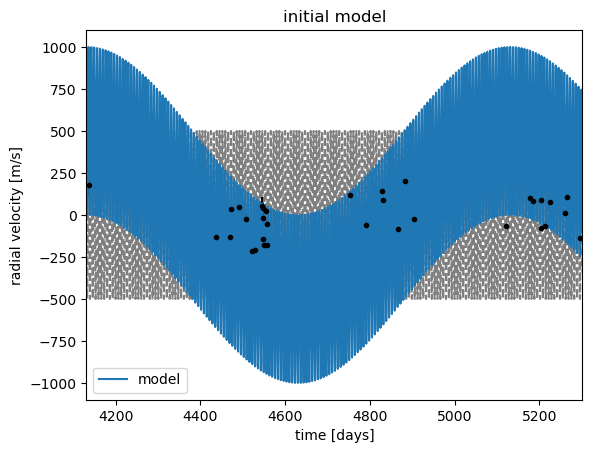

In [23]:
plt.errorbar(time, rad_vel-map_soln['RVMean'], yerr = rv_err, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    #plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5, zorder = 100)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")


plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
#plt.xlim(4550,4560)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [20]:
model.RVMean

RVMean ~ Deterministic

In [22]:
map_soln['RVMean']

array([250.8667253 , 250.8667253 , 250.8667253 , 250.8667253 ,
       250.8667253 , 250.8667253 , 250.8667253 , 250.8667253 ,
       250.8667253 , 250.8667253 , 250.8667253 , 250.8667253 ,
       250.8667253 , 250.8667253 , 250.8667253 , 166.72163108,
       166.72163108, 166.72163108, 166.72163108, -58.73542139,
       -58.73542139, -58.73542139, -58.73542139,  53.69558125,
        53.69558125,  53.69558125,  53.69558125,  53.69558125,
        53.69558125,  53.69558125,  53.69558125,  53.69558125,
        53.69558125])

In [ ]:
plt.errorbar(time, rad_vel, yerr = rv_err, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5, zorder = 100)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")


plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

In [18]:
print('*** MAP Fit Parameters ***')
for thiskey in list(map_soln.keys())[:-1]:
    if bool(thiskey.find('__')+1):
        continue
    print('{}: {}'.format(thiskey, map_soln[thiskey]))

*** MAP Fit Parameters ***
mean: -1.332995381559654e-10
period: [  6.72547057 893.7287885 ]
t0: [2388.84599056 3380.82224483]
RVOffset: [250.8667253  166.72163108 -58.73542139  53.69558125]
u: [0.70710678 0.        ]
m_star: 0.8197747713547734
r_star: 0.7899430305549717
teff: 4869.06505153785
st_lum: 0.31489399643611404
ror: [0.5 0.5]
r_pl: [0.395 0.01 ]
m_pl: [15000.04999808 15000.04999808]
density_pl: [1.03413240e+00 6.37334504e+04]
K: [117.48302019  67.92444825]
b: [0.5 0.5]
RVJitter: [11.81906914 12.05609254 25.72337248 16.72957153]
RVMean: [250.8667253  250.8667253  250.8667253  250.8667253  250.8667253
 250.8667253  250.8667253  250.8667253  250.8667253  250.8667253
 250.8667253  250.8667253  250.8667253  250.8667253  250.8667253
 166.72163108 166.72163108 166.72163108 166.72163108 -58.73542139
 -58.73542139 -58.73542139 -58.73542139  53.69558125  53.69558125
  53.69558125  53.69558125  53.69558125  53.69558125  53.69558125
  53.69558125  53.69558125  53.69558125]
RVError: [ 59.8

In [15]:
print('*** MAP Fit Parameters ***')
for thiskey in list(map_soln.keys())[:-1]:
    if bool(thiskey.find('__')+1):
        continue
    print('{}: {}'.format(thiskey, map_soln[thiskey]))

*** MAP Fit Parameters ***
mean: -1.332995381559654e-10
period: [  6.72547057 893.7287885 ]
t0: [2388.84599056 3380.82224483]
RVOffset: [250.8667253  166.72163108 -58.73542139  53.69558125]
u: [0.70710678 0.        ]
m_star: 0.8197747713547734
r_star: 0.7899430305549717
teff: 4869.06505153785
st_lum: 0.31489399643611404
ror: [0.5 0.5]
r_pl: [0.395 0.01 ]
m_pl: [15000.04999808 15000.04999808]
density_pl: [1.03413240e+00 6.37334504e+04]
K: [117.48302019  67.92444825]
b: [0.5 0.5]
RVJitter: [11.81906914 12.05609254 25.72337248 16.72957153]
rho_circ: [2.34468157e+00 5.28667434e+03]
aor: [ 18.0858097 208.4975166]
vrad: [[ 117.45264154   56.2488033 ]
 [ -80.28453522  -61.56604864]
 [ -55.41882194  -66.60051727]
 [  87.75052692  -66.86595722]
 [ 107.49347165  -67.86012231]
 [  64.23694993  -67.79547939]
 [-115.20829578  -66.90051179]
 [-107.21020175  -66.24517796]
 [ 109.61762503  -64.14655617]
 [  99.61972975  -63.98923005]
 [   8.96101683  -63.82720615]
 [ -88.51069364  -63.6631228 ]
 [-114

In [ ]:
# Add gamma-offset